<a href="https://colab.research.google.com/github/0xfffddd/Coding/blob/main/ML_Final_Project_linear_regression_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Load the data

from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import pyarrow.parquet as pq

BASE = "/content/drive/MyDrive/GatingModelData2"

all_dfs = []

for year in range(2001, 2006):
    year_path = os.path.join(BASE, f"year={year}")
    if not os.path.exists(year_path):
        raise FileNotFoundError(f"Folder not found: {year_path}")

    files = sorted([f for f in os.listdir(year_path) if f.endswith(".parquet")])

    print(f"Year {year}: {len(files)} parquet files")

    for f in files:
        fp = os.path.join(year_path, f)
        table = pq.read_table(fp)
        df_m = table.to_pandas()
        all_dfs.append(df_m)

df = pd.concat(all_dfs, ignore_index=True)

print("Loaded shape:", df.shape)
print(df[["permno", "month", "ret_excess"]].head())

Mounted at /content/drive
Year 2001: 12 parquet files
Year 2002: 12 parquet files
Year 2003: 12 parquet files
Year 2004: 12 parquet files
Year 2005: 12 parquet files
Loaded shape: (421613, 181)
   permno      month  ret_excess
0   10001 2001-01-01         NaN
1   10002 2001-01-01         NaN
2   10012 2001-01-01         NaN
3   10016 2001-01-01         NaN
4   10019 2001-01-01         NaN


In [2]:
#check data charastics
df.dtypes

,0
permno,int64
month,datetime64[ns]
ret_excess,float64
mktcap_lag,float64
macro_dp,float64
...,...
sic2_86,int8
sic2_87,int8
sic2_89,int8
sic2_99,int8


In [3]:
# Data Cleaning
import numpy as np
import pandas as pd

# 1) basic clean
df = df.sort_values(["month", "permno"]).reset_index(drop=True)
df = df.dropna(subset=["ret_excess"])

# 2) choose features: macro + characteristic + sic2
macro_cols = [c for c in df.columns if c.startswith("macro_")]
char_cols  = [c for c in df.columns if c.startswith("characteristic_")]
sic_cols   = [c for c in df.columns if c.startswith("sic2_")]

features = macro_cols + char_cols[:20] + sic_cols
target = "ret_excess"

df_model = df[["permno","month",target] + features].copy()

df_model[features] = df_model[features].fillna(0.0)

print(df_model.shape)
df_model.head()

(304158, 105)


,permno,month,ret_excess,macro_dp,macro_ep,macro_bm,macro_ntis,macro_tbl,macro_tms,macro_dfy,...,sic2_79,sic2_80,sic2_81,sic2_82,sic2_83,sic2_84,sic2_86,sic2_87,sic2_89,sic2_99
8069,10001,2001-02-01,-0.016458,-4.436387,-3.338498,0.15045,-0.003193,0.0515,0.0047,0.0078,...,0,0,0,0,0,0,0,0,0,0
8070,10002,2001-02-01,0.058700,-4.436387,-3.338498,0.15045,-0.003193,0.0515,0.0047,0.0078,...,0,0,0,0,0,0,0,0,0,0
8071,10012,2001-02-01,-0.337133,-4.436387,-3.338498,0.15045,-0.003193,0.0515,0.0047,0.0078,...,0,0,0,0,0,0,0,0,0,0
8072,10016,2001-02-01,-0.017350,-4.436387,-3.338498,0.15045,-0.003193,0.0515,0.0047,0.0078,...,0,0,0,0,0,0,0,0,0,0
8073,10019,2001-02-01,-0.170467,-4.436387,-3.338498,0.15045,-0.003193,0.0515,0.0047,0.0078,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#rolling window train
# 2Y~1M`1M
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def rolling_monthly_one_step(
    dfm: pd.DataFrame,
    features: list,
    target: str = "ret_excess",
    train_months: int = 24
):
    dfm = dfm.sort_values(["month","permno"]).reset_index(drop=True)

    months = pd.DatetimeIndex(pd.to_datetime(dfm["month"].unique())).sort_values()

    month_data = {}
    for m, g in dfm.groupby("month"):
        month_data[pd.Timestamp(m)] = (
            g[features].to_numpy(),
            g[target].to_numpy(),
            g["permno"].to_numpy(),
        )

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=1.0, random_state=0))
    ])

    preds = []

    for i in range(train_months, len(months)):
        train_ms = months[i-train_months:i]
        test_m   = months[i]

        X_train = np.vstack([month_data[m][0] for m in train_ms])
        y_train = np.concatenate([month_data[m][1] for m in train_ms])

        X_test, y_test, permno_test = month_data[test_m]

        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)

        out = pd.DataFrame({
            "month": test_m,
            "permno": permno_test,
            "y_true": y_test,
            "y_pred": y_hat
        })
        preds.append(out)

        if (i - train_months) % 12 == 0:
            print(f"Done up to {test_m.strftime('%Y-%m')} | train_rows={len(y_train):,} test_rows={len(y_test):,}")

    return pd.concat(preds, ignore_index=True)

In [5]:
# test on 2001 to 2005
pred_df_monthly = rolling_monthly_one_step(
    dfm=df_model,
    features=features,
    target="ret_excess",
    train_months=24
)
import numpy as np

rmse = np.sqrt(np.mean((pred_df_monthly["y_true"] -
                        pred_df_monthly["y_pred"])**2))

print("Overall RMSE:", rmse)

Done up to 2003-02 | train_rows=134,629 test_rows=5,138
Done up to 2004-02 | train_rows=123,697 test_rows=4,844
Done up to 2005-02 | train_rows=117,213 test_rows=4,779
Overall RMSE: 0.1682607294058237


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Year 2001: 12 parquet files
Year 2002: 12 parquet files
Year 2003: 12 parquet files
Year 2004: 12 parquet files
Year 2005: 12 parquet files
Year 2006: 12 parquet files
Year 2007: 12 parquet files
Year 2008: 12 parquet files
Year 2009: 12 parquet files
Year 2010: 12 parquet files
Year 2011: 12 parquet files
Year 2012: 12 parquet files
Year 2013: 12 parquet files
Year 2014: 12 parquet files
Year 2015: 12 parquet files
Year 2016: 12 parquet files
Year 2017: 12 parquet files
Year 2018: 12 parquet files
Year 2019: 12 parquet files
Year 2020: 12 parquet files
Year 2021: 12 parquet files
Full loaded shape: (1520078, 181)
df_model shape: (1027681, 179)
n_features: 176
Done up to 2003-02 | train_rows=134,629 test_rows=5,138
Done up to 2004-02 | train_rows=123,697 test_rows=4,844
Done up to 2005-02 | train_rows=117,213 test_rows=4,779
Done up to 2006-02 | train_rows=11

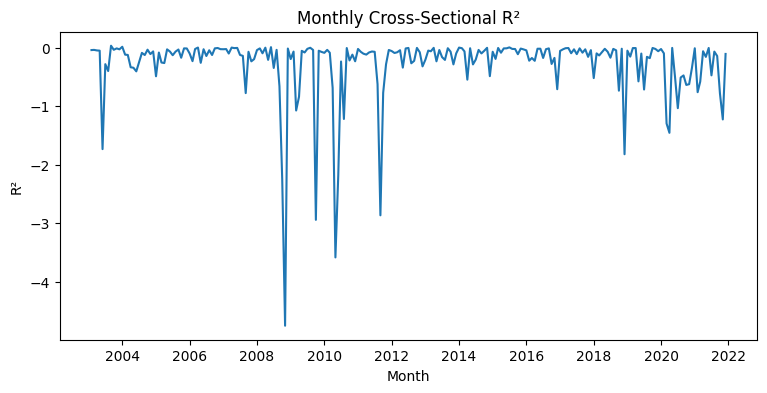

/tmp/ipython-input-2597276013.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = pred_df.groupby("month", group_keys=False).apply(assign_group)


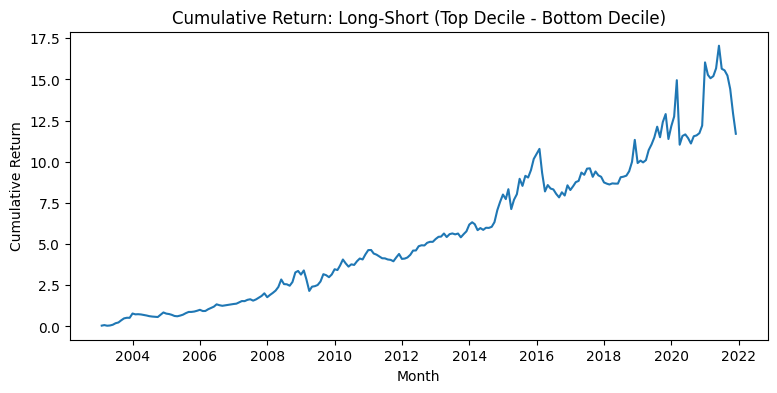

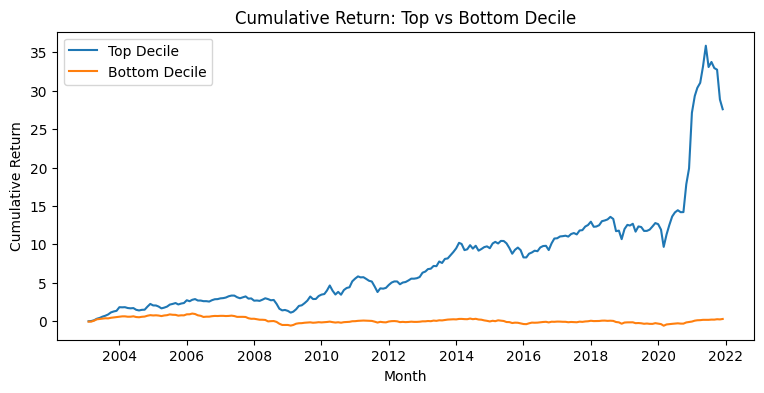

group       long_short
month                 
2021-08-01   -0.005953
2021-09-01   -0.019044
2021-10-01   -0.050147
2021-11-01   -0.096825
2021-12-01   -0.088238


In [6]:
#full version 2001-2021


# 0) Setup + Mount Drive

from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt


BASE = "/content/drive/MyDrive/GatingModelData2"

all_dfs = []
for year in range(2001, 2022):
    year_path = os.path.join(BASE, f"year={year}")
    if not os.path.exists(year_path):
        raise FileNotFoundError(f"Folder not found: {year_path}")

    files = sorted([f for f in os.listdir(year_path) if f.endswith(".parquet")])
    print(f"Year {year}: {len(files)} parquet files")

    for f in files:
        fp = os.path.join(year_path, f)
        table = pq.read_table(fp)
        all_dfs.append(table.to_pandas())

df = pd.concat(all_dfs, ignore_index=True)
print("Full loaded shape:", df.shape)


df["month"] = pd.to_datetime(df["month"])
df = df.sort_values(["month", "permno"]).reset_index(drop=True)

# Drop missing target
df = df.dropna(subset=["ret_excess"])

# Feature columns
macro_cols = [c for c in df.columns if c.startswith("macro_")]
char_cols  = [c for c in df.columns if c.startswith("characteristic_")]
sic_cols   = [c for c in df.columns if c.startswith("sic2_")]

features = macro_cols + char_cols + sic_cols
target = "ret_excess"

df_model = df[["permno", "month", target] + features].copy()

# Missing values: simple baseline (later you can improve)
df_model[features] = df_model[features].fillna(0.0)

# Reduce memory (important for full sample)
float_cols = macro_cols + char_cols
df_model[float_cols] = df_model[float_cols].astype(np.float32)

print("df_model shape:", df_model.shape)
print("n_features:", len(features))


def rolling_monthly_one_step(dfm: pd.DataFrame, features: list, target: str="ret_excess", train_months: int=24):
    dfm = dfm.sort_values(["month","permno"]).reset_index(drop=True)
    months = pd.DatetimeIndex(dfm["month"].unique()).sort_values()

    # cache each month's arrays
    month_data = {}
    for m, g in dfm.groupby("month"):
        month_data[pd.Timestamp(m)] = (
            g[features].to_numpy(),
            g[target].to_numpy(),
            g["permno"].to_numpy(),
        )

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=1.0, random_state=0))
    ])

    preds = []
    for i in range(train_months, len(months)):
        train_ms = months[i-train_months:i]
        test_m   = months[i]

        X_train = np.vstack([month_data[m][0] for m in train_ms])
        y_train = np.concatenate([month_data[m][1] for m in train_ms])

        X_test, y_test, permno_test = month_data[test_m]

        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)

        preds.append(pd.DataFrame({
            "month": test_m,
            "permno": permno_test,
            "y_true": y_test,
            "y_pred": y_hat
        }))

        if (i - train_months) % 12 == 0:
            print(f"Done up to {test_m.strftime('%Y-%m')} | train_rows={len(y_train):,} test_rows={len(y_test):,}")

    return pd.concat(preds, ignore_index=True)


pred_df = rolling_monthly_one_step(df_model, features, target=target, train_months=24)
print("pred_df shape:", pred_df.shape)


rmse = float(np.sqrt(np.mean((pred_df["y_true"] - pred_df["y_pred"])**2)))
print("Overall RMSE:", rmse)

def monthly_r2_table(pred_df: pd.DataFrame):
    rows = []
    for m, g in pred_df.groupby("month"):
        y = g["y_true"].to_numpy()
        yhat = g["y_pred"].to_numpy()
        ss_res = np.sum((y - yhat)**2)
        ss_tot = np.sum((y - y.mean())**2)
        r2 = np.nan if ss_tot == 0 else 1 - ss_res/ss_tot
        rows.append((pd.Timestamp(m), r2, len(g)))
    r2_df = pd.DataFrame(rows, columns=["month","r2","n"]).dropna()
    return r2_df

r2_df = monthly_r2_table(pred_df)
print("Mean monthly R2:", float(r2_df["r2"].mean()))
print("Median monthly R2:", float(r2_df["r2"].median()))

# plot monthly R2
plt.figure(figsize=(9,4))
plt.plot(r2_df["month"], r2_df["r2"])
plt.title("Monthly Cross-Sectional R²")
plt.xlabel("Month")
plt.ylabel("R²")
plt.show()


def decile_backtest(pred_df: pd.DataFrame, n_groups: int = 10):
    pred_df = pred_df.copy()
    pred_df["month"] = pd.to_datetime(pred_df["month"])

    def assign_group(g):
        # rank to avoid qcut issues with duplicated predictions
        r = g["y_pred"].rank(method="first")
        g["group"] = pd.qcut(r, n_groups, labels=False) + 1  # 1..10
        return g

    tmp = pred_df.groupby("month", group_keys=False).apply(assign_group)

    grp_ret = (tmp.groupby(["month","group"])["y_true"]
                 .mean()
                 .reset_index(name="ret"))

    wide = grp_ret.pivot(index="month", columns="group", values="ret").sort_index()

    # long-short (10-1)
    wide["long_short"] = wide[n_groups] - wide[1]

    # cumulative returns (simple, no costs)
    cum = (1 + wide.fillna(0)).cumprod() - 1
    return wide, cum

wide_ret, cum_ret = decile_backtest(pred_df, n_groups=10)

# plot long-short cumulative return
plt.figure(figsize=(9,4))
plt.plot(cum_ret.index, cum_ret["long_short"])
plt.title("Cumulative Return: Long-Short (Top Decile - Bottom Decile)")
plt.xlabel("Month")
plt.ylabel("Cumulative Return")
plt.show()

# (optional) plot top & bottom decile cumulative returns
plt.figure(figsize=(9,4))
plt.plot(cum_ret.index, cum_ret[10], label="Top Decile")
plt.plot(cum_ret.index, cum_ret[1], label="Bottom Decile")
plt.title("Cumulative Return: Top vs Bottom Decile")
plt.xlabel("Month")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

# quick sanity check output
print(wide_ret[["long_short"]].tail())

In [7]:
#Naive status calculation
import numpy as np

rmse_model = np.sqrt(np.mean((pred_df["y_true"] - pred_df["y_pred"])**2))
rmse_naive = np.sqrt(np.mean(pred_df["y_true"]**2))

print("Model RMSE:", rmse_model)
print("Naive RMSE:", rmse_naive)
print("Improvement:", 1 - rmse_model/rmse_naive)

Model RMSE: 0.19353466374242861
Naive RMSE: 0.17915234944101185
Improvement: -0.08027979731380697


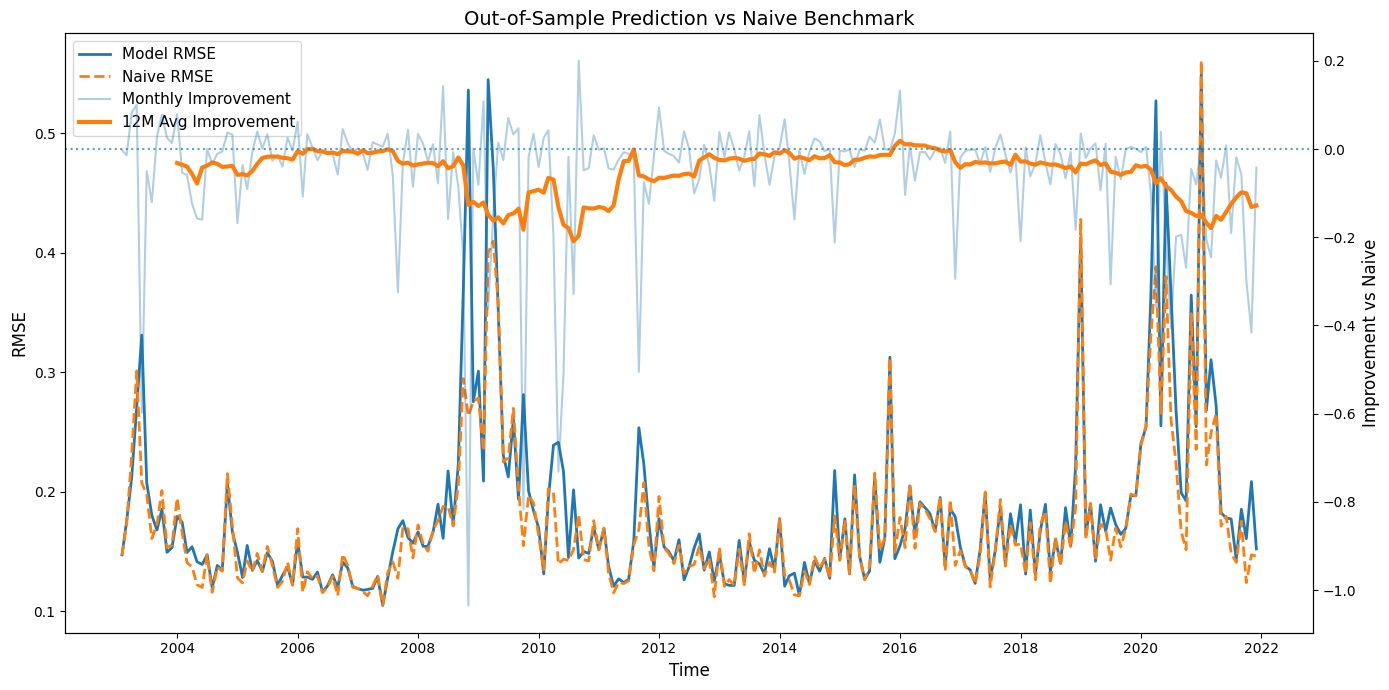

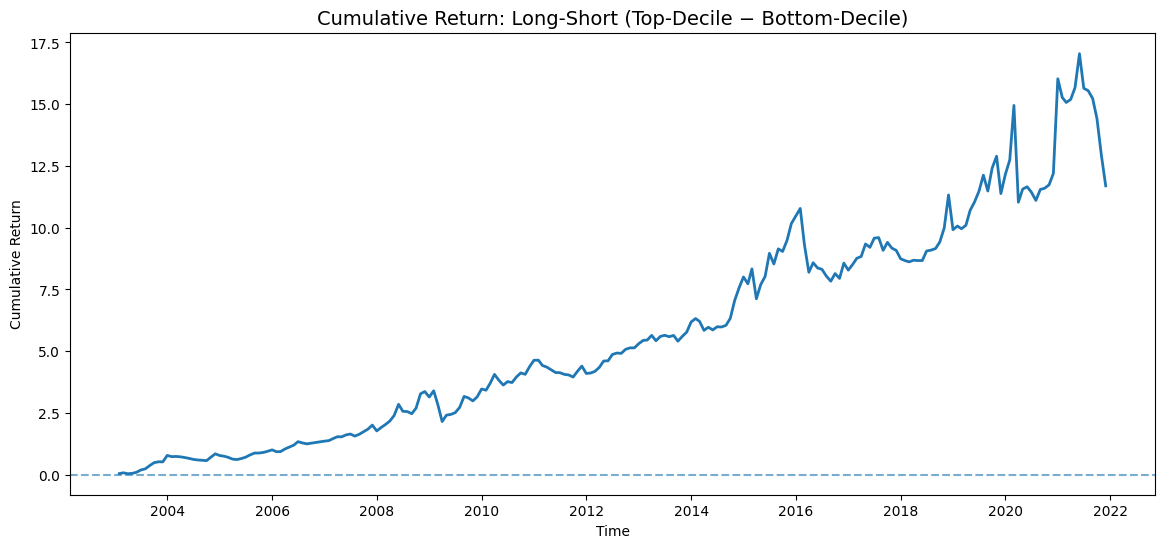

In [8]:
import numpy as np
import pandas as pd

# ===== monthly metrics from pred_df =====
rows = []

for m, g in pred_df.groupby("month"):
    y = g["y_true"].values
    yhat = g["y_pred"].values

    model_rmse = np.sqrt(np.mean((y - yhat)**2))
    naive_rmse = np.sqrt(np.mean(y**2))  # naive = predict 0
    improvement = 1 - model_rmse / naive_rmse

    rows.append([m, model_rmse, naive_rmse, improvement])

metrics = pd.DataFrame(rows, columns=[
    "month","model_rmse","naive_rmse","improvement"
]).sort_values("month")

metrics.head()
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14,7))

# ===== RMSE lines =====
ax1.plot(metrics["month"], metrics["model_rmse"],
         linewidth=2, label="Model RMSE")

ax1.plot(metrics["month"], metrics["naive_rmse"],
         linestyle="--", linewidth=2, label="Naive RMSE")

ax1.set_xlabel("Time", fontsize=12)
ax1.set_ylabel("RMSE", fontsize=12)
ax1.set_title("Out-of-Sample Prediction vs Naive Benchmark", fontsize=14)

# ===== second axis improvement =====
ax2 = ax1.twinx()

ax2.plot(metrics["month"], metrics["improvement"],
         alpha=0.35, linewidth=1.5, label="Monthly Improvement")

metrics["improve_smooth"] = metrics["improvement"].rolling(12).mean()

ax2.plot(metrics["month"], metrics["improve_smooth"],
         linewidth=3, label="12M Avg Improvement")

ax2.set_ylabel("Improvement vs Naive", fontsize=12)

ax2.axhline(0, linestyle=":", alpha=0.7)

# ===== legend merge =====
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(lines1 + lines2, labels1 + labels2,
           loc="upper left", fontsize=11)

plt.tight_layout()
plt.show()
plt.figure(figsize=(14,6))

plt.plot(cum_ret.index, cum_ret["long_short"], linewidth=2)

plt.title("Cumulative Return: Long-Short (Top-Decile − Bottom-Decile)", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Cumulative Return")

plt.axhline(0, linestyle="--", alpha=0.6)

plt.show()

In [9]:
import numpy as np
import pandas as pd
from pathlib import Path


df_pred = pred_df.copy()
MODEL_NAME = "Ridge"

df_pred["month"] = pd.to_datetime(df_pred["month"])

metrics = (
    df_pred.groupby("month")
    .apply(lambda g: pd.Series({
        "model_rmse": float(np.sqrt(np.mean((g["y_true"].values - g["y_pred"].values) ** 2))),
        "naive_rmse": float(np.sqrt(np.mean((g["y_true"].values) ** 2))),  # naive = predict 0
    }))
    .reset_index()
)
metrics["improvement"] = 1 - metrics["model_rmse"] / metrics["naive_rmse"]
metrics["model"] = MODEL_NAME


def long_short_one_month(g: pd.DataFrame) -> float:
    g = g.dropna(subset=["y_pred", "y_true"]).copy()
    if len(g) < 50:
        return np.nan

    r = g["y_pred"].rank(method="first")
    q = pd.qcut(r, 10, labels=False, duplicates="drop")

    top = g.loc[q == q.max(), "y_true"].mean()
    bottom = g.loc[q == q.min(), "y_true"].mean()
    return float(top - bottom)

ls = (
    df_pred.groupby("month")
    .apply(long_short_one_month)
    .rename("long_short")
    .reset_index()
    .sort_values("month")
)


ls["long_short"] = ls["long_short"].fillna(0.0)
ls["cum_ls"] = (1 + ls["long_short"]).cumprod() - 1
ls["model"] = MODEL_NAME


out_dir = Path("model_exports")
out_dir.mkdir(exist_ok=True)

metrics_path = out_dir / f"metrics_{MODEL_NAME}.csv"
ls_path = out_dir / f"longshort_{MODEL_NAME}.csv"

metrics.to_csv(metrics_path, index=False)
ls.to_csv(ls_path, index=False)

print("Saved:", metrics_path, "and", ls_path)
print("Rows:", "metrics =", len(metrics), "| longshort =", len(ls))

/tmp/ipython-input-1402033909.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Saved: model_exports/metrics_Ridge.csv and model_exports/longshort_Ridge.csv
Rows: metrics = 227 | longshort = 227


/tmp/ipython-input-1402033909.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(long_short_one_month)
